In [1]:
import numpy as np 
import pandas as pd 

In [13]:
import matplotlib.pyplot as plt 

In [11]:
df = pd.read_csv('foot_traffic.csv')

In [12]:
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


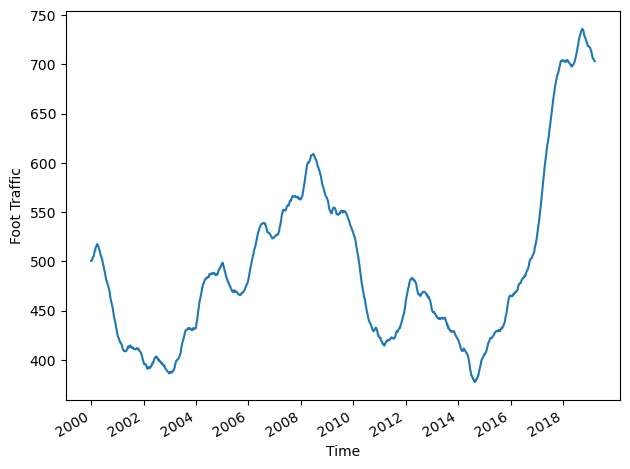

In [19]:
fig, ax = plt.subplots()

plt.plot(df)
ax.set_xlabel('Time') 
ax.set_ylabel('Foot Traffic') 

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate() 
plt.tight_layout()

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [16]:
adf_res = adfuller(df)
print(f'ADF Stat: {adf_res[0]}')
print(f'p-value: {adf_res[1]}')

ADF Stat: -1.1758885999240802
p-value: 0.6838808917896166


In [20]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)


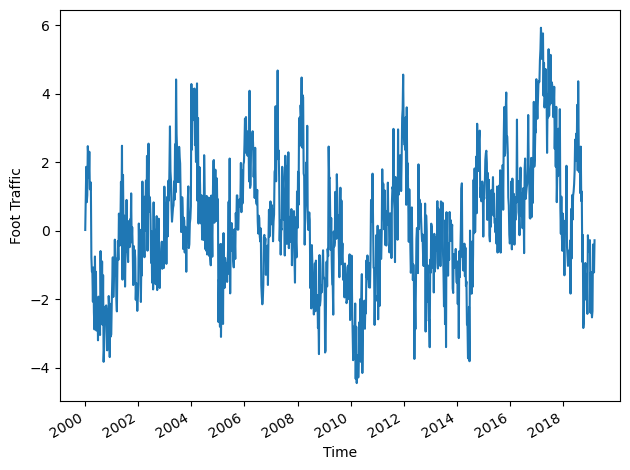

In [21]:
fig, ax = plt.subplots()

plt.plot(foot_traffic_diff)
ax.set_xlabel('Time') 
ax.set_ylabel('Foot Traffic') 

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate() 
plt.tight_layout()

In [22]:
adf_res = adfuller(foot_traffic_diff)
print(f'ADF Stat: {adf_res[0]}')
print(f'p-value: {adf_res[1]}')

ADF Stat: -5.268231347422039
p-value: 6.3693176547814515e-06


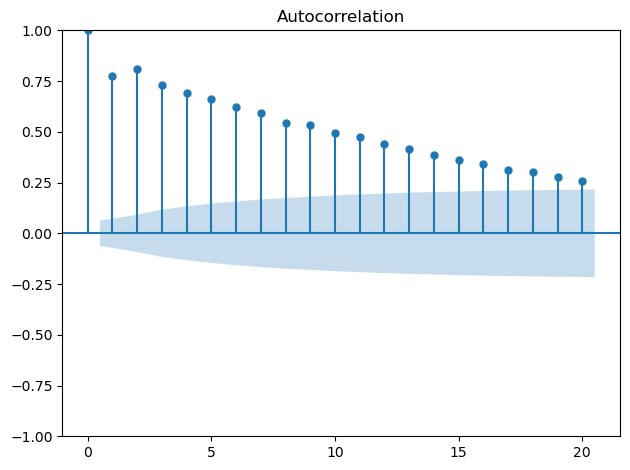

In [23]:
plot_acf(foot_traffic_diff, lags=20); 

plt.tight_layout()
#here the acf plot slowly decays, which suggests that we have an autoregressive process.
#as we have significant corelation beyond lag 0 we know our process is not a random walk . 



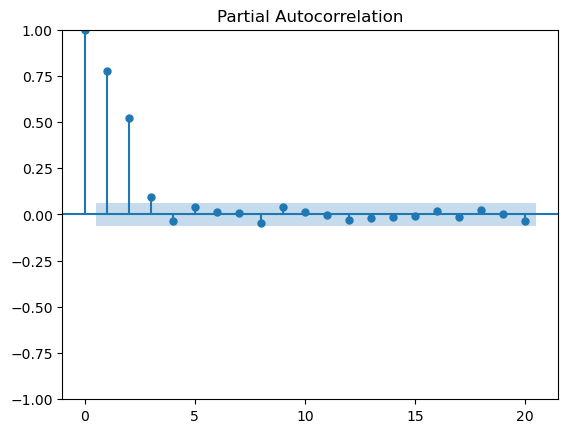

In [24]:
plot_pacf(foot_traffic_diff, lags=20);
# so this is an AR(3) process.

In [25]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train)) 
print(len(test))

947
52


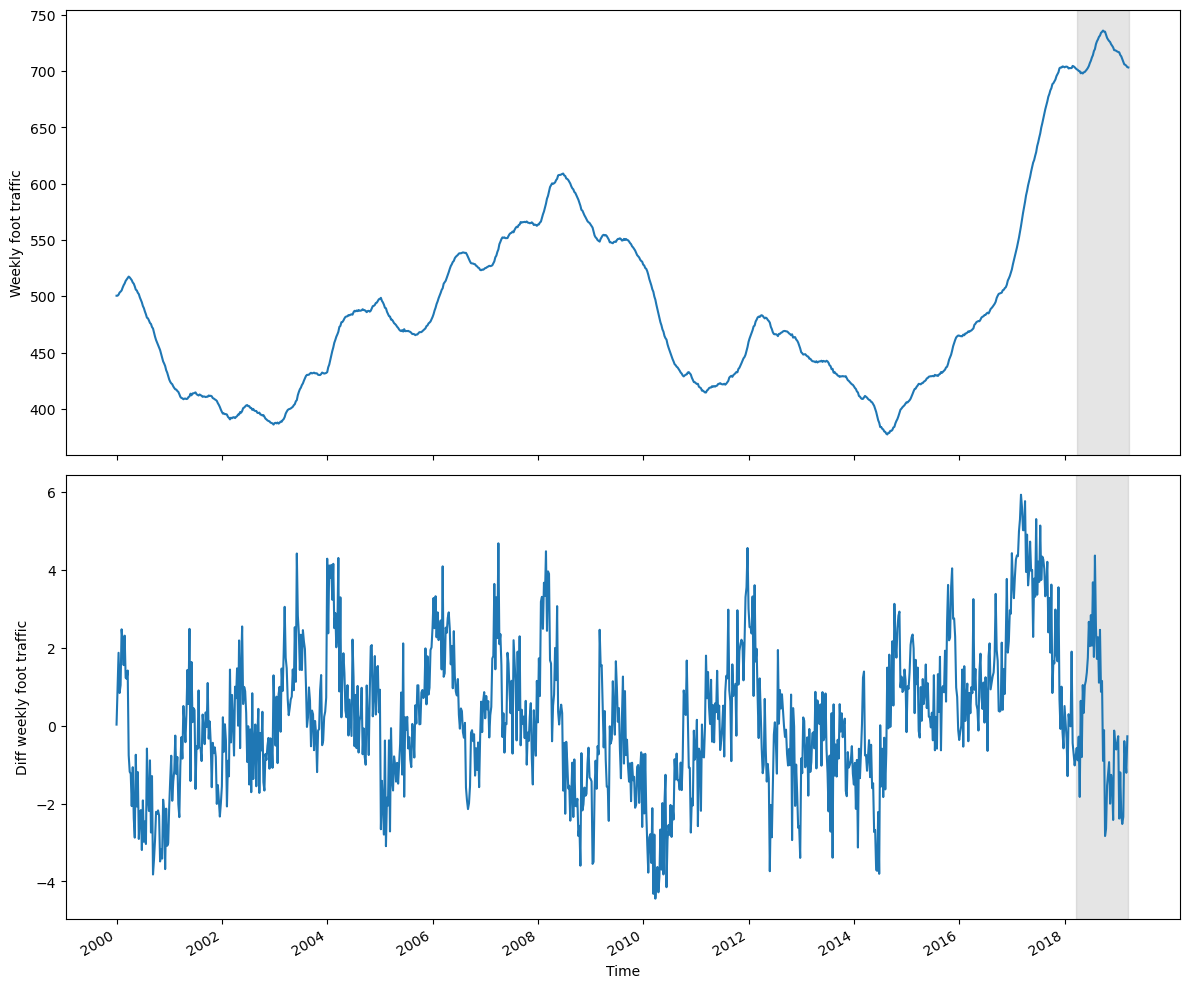

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,10)) 

ax1.plot(df['foot_traffic']) 
ax1.set_xlabel('Time') 
ax1.set_ylabel('Weekly foot traffic') 
ax1.axvspan(948, 1000, color='#808080', alpha=0.2) 

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time') 
ax2.set_ylabel('Diff weekly foot traffic') 
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2)) 

fig.autofmt_xdate() 
plt.tight_layout()

In [29]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list: 
    total_len = train_len + horizon 
    end_idf = train_len 

    if method == 'mean': 
        pred_mean=[] 
        
        for i in range(train_len, total_len, window): 
            mean = np.mean(df[:i].values) 
            pred_mean.extend(mean for _ in range(window)) 

        return pred_mean 
    elif method == 'last': 
        pred_last_value = []

        for i in range(train_len, total_len, window):

            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method =='AR': 
        pred_AR = [] 

        for i in range(train_len, total_len, window): 
            model = SARIMAX(df[:i], order=(3,0,0)) 
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1) 
            oos_pred = predictions.predicted_mean.iloc[-window:] 
            pred_AR.extend(oos_pred)
        return pred_AR
    



In [30]:
TRAIN_LEN = len(train) 
HORIZON = len(test) 
WINDOW = 1 

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR= rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean 
test['last_value'] = pred_last_value 
test['pred_AR'] = pred_AR
test.head()

C:\Users\ibra6\AppData\Local\Temp\ipykernel_29860\627849901.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
C:\Users\ibra6\AppData\Local\Temp\ipykernel_29860\627849901.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['last_value'] = pred_last_value
C:\Users\ibra6\AppData\Local\Temp\ipykernel_29860\627849901.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,foot_traffic_diff,pred_mean,last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


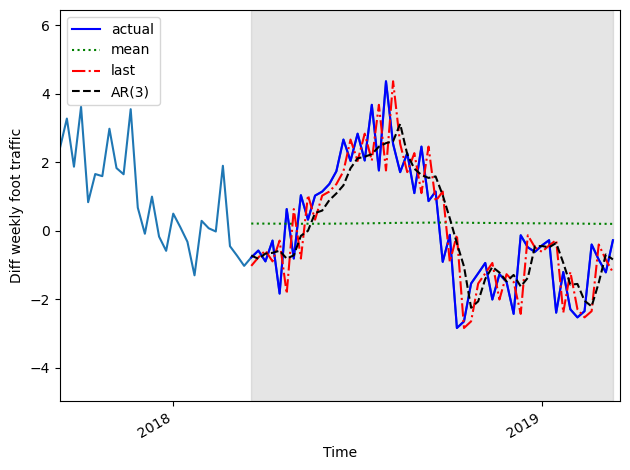

In [31]:
fig, ax = plt.subplots() 

ax.plot(df_diff['foot_traffic_diff']) 
ax.plot(test['foot_traffic_diff'], 'b-', label='actual') 
ax.plot(test['pred_mean'], 'g:', label='mean') 
ax.plot(test['last_value'], 'r-.', label='last') 
ax.plot(test['pred_AR'], 'k--', label='AR(3)') 

ax.legend(loc=2) 

ax.set_xlabel('Time') 
ax.set_ylabel('Diff weekly foot traffic') 

ax.axvspan(947, 998, color='#808080', alpha=0.2) 

ax.set_xlim(920, 999) 

plt.xticks([936, 988], [2018, 2019]) 

fig.autofmt_xdate() 
plt.tight_layout()


In [37]:
from sklearn.metrics import mean_squared_error 

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean']) 
mse_last = mean_squared_error(test['foot_traffic_diff'], test['last_value'])

mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR']) 
print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.924247916388977


In [39]:
df['pred_foot_traffic'] = pd.Series() 
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

C:\Users\ibra6\AppData\Local\Temp\ipykernel_29860\2732905436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()


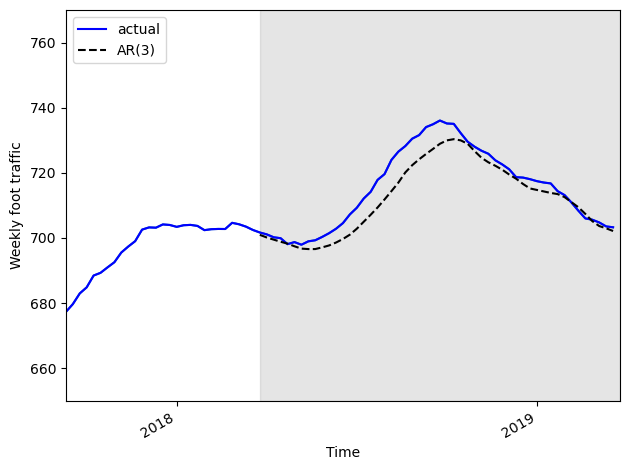

In [40]:
fig, ax = plt.subplots() 

ax.plot(df['foot_traffic']) 
ax.plot(df['foot_traffic'], 'b-', label='actual') 
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)') 

ax.legend(loc=2) 

ax.set_xlabel('Time')
ax.set_ylabel('Weekly foot traffic') 

ax.axvspan(948, 1000, color='#808080', alpha=0.2) 

ax.set_xlim(920, 1000) 
ax.set_ylim(650, 770) 

plt.xticks([936, 988], [2018, 2019]) 

fig.autofmt_xdate() 
plt.tight_layout()

In [41]:
from sklearn.metrics import mean_absolute_error#

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:]) 

print(mae_AR_undiff)

3.4780335587620925
